In [ ]:
from torch.autograd import Function

In [ ]:
class Exp(Function):
  """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

  @staticmethod
  def forward(ctx, i):
    """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
    """
    result = i.exp()
    ctx.save_for_backward(result)
    return result

  @staticmethod
  def backward(ctx, grad_output):
    """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
    """
    print(ctx.saved_tensors)
    result, = ctx.saved_tensors
    return grad_output * result

In [ ]:
# Use it by calling the apply method
input = torch.tensor(2.0, requires_grad=True)
output = Exp.apply(input)
output

tensor(7.3891, grad_fn=<ExpBackward>)

In [ ]:
import math
math.exp(2.0)

7.38905609893065

In [ ]:
output.backward()
show_tensor_params(output)
show_tensor_params(input)

(tensor(7.3891, grad_fn=<ExpBackward>),)
---
data - 7.389056205749512
grad - None
grad_fn - <torch.autograd.function.ExpBackward object at 0x7f76064c6b80>
req_grad - True
is_leaf - False
---
data - 2.0
grad - 7.389056205749512
grad_fn - None
req_grad - True
is_leaf - True


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


**Задание**: реализуйте backward для Polynomial 0.5 * (5 * input ** 3 - 3 * input)

In [ ]:
import torch


class Polynomial(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return (7.5 * input ** 2 - 1.5) * grad_output

Практическое задание: написать собственный движок автоматического дифференцирования, а именно: реализовать

In [ ]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None # function 
        self._prev = set(_children) # set of Value objects
        self._op = _op # the op that produced this node, string ('+', '-', ....)

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(other.data + self.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(other.data * self.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), '**')

        def _backward():
            self.grad += out.grad * other * (self.data ** (other - 1))
        out._backward = _backward

        return out

    def relu(self):
        out = Value(self.data if self.data > 0 else 0, (self,), 'relu')

        def _backward():
            self.grad += out.grad if self.data > 0 else 0
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [ ]:
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
  
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    
    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    print(xmg, xpt, xpt.grad)
    assert xmg.grad == xpt.grad.item()


def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

In [ ]:
a = Value(-4.0)
b = Value(2.0)
d = Value(3.0)

In [ ]:
c = a + b
e = c * d
e.backward()

In [ ]:
test_sanity_check()

Value(data=-4.0, grad=46.0) tensor([-4.], dtype=torch.float64, requires_grad=True) tensor([46.], dtype=torch.float64)


In [ ]:
test_more_ops()

# Обучение на основе собственной бибилотеки

## Многослойный перцептрон на основе класса Value

In [ ]:
import random

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    #                  nin hao ma
    def __init__(self, nin, nonlin=True):
        self.w = [Value(1) for i in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        mid = sum([self.w[i] * x[i] for i in range(len(x))]) + self.b
        act = mid.relu() if self.nonlin else mid
        return act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, kwargs['nonlin']) for i in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        params = []
        for n in self.neurons:
            params += n.parameters()
        return params

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=(i!=len(nouts)-1)) for i in range(len(nouts))]
        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def parameters(self):
        params = []
        for l in self.layers:
            params += l.parameters()
        return params

    def __repr__(self):
        repr = '\n'.join(str(layer) for layer in self.layers)
        return f"MLP of [{repr}]"

## Обучение многослойного перцептрона

Сам перцептрон

In [ ]:
model = MLP(3, [4, 4, 1])
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)]
Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)]
Layer of [LinearNeuron(4)]]
number of parameters 41


Набор данных

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
history = []
for k in range(2_000):

    # forward
    out = [model(x) for x in xs]

    # calculate loss (mean square error)
    acc = 0
    total_loss = 0
    for y_pred, y_true in zip(out, ys):
      total_loss += (y_pred - y_true) ** 2
      acc += round(y_pred.data) == y_true
    total_loss = total_loss / len(ys)
    acc = acc / len(ys)
    history.append(total_loss.data)
    
    # backward (zero_grad + backward)
    model.zero_grad()
    total_loss.backward()
    
    # update
    learning_rate = 0.001
    for p in model.parameters():
        p.data = p.data - learning_rate * p.grad
    
    
    if k % 400 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1889.0, accuracy 0.0%
step 400 loss 0.8491560611586679, accuracy 0.0%
step 800 loss 0.5598632663471556, accuracy 25.0%
step 1200 loss 0.13218400504446332, accuracy 75.0%
step 1600 loss 0.05611870318542738, accuracy 100.0%


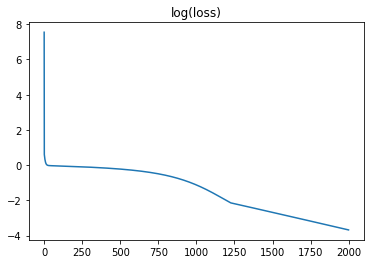

In [ ]:
plt.title("log(loss)")
plt.plot(range(len(history)), [np.log(h) for h in history])
plt.show()

# Домашнее задание

**Домашнее задание 1.** Доделать практику. Оформить код в три отдельных модуля `autograd`, `nn`, `train`

**Домашнее задание 2 (Опционально).** Создать свою функцию softmax, наследуемую от `torch.autograd.Function` и имплементировать forward и backward проход. Сравнить со стандартной функцией в Pytorch. 
[Создание функций](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html) [Софтмакс](https://congyuzhou.medium.com/softmax-3408fb42d55a)

In [ ]:
# Ваш код

**Домашнее задание 3 (Опционально).** Добавить функцию софтмакс в собственну библиотеку автоматического дифференцирования. Сравнить с пунктом 2

In [ ]:
# Ваш код

**Домашнее задание 4 (Опционально).** Добавить визуализацию обучения. Потом мы пройдем более подробно.

https://docs.wandb.ai/guides/integrations/pytorch

https://docs.wandb.ai/ref/python/watch  

https://docs.wandb.ai/guides/track/jupyter

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
import wandb
run = wandb.init(project="polynom_learning_")

In [ ]:
run.finish()